In [1]:
using Jutul
using JutulDarcy
using LinearAlgebra
using GLMakie

# Example demonstrating optimzation of parameters against observations
We create a simple test problem: A 1D nonlinear displacement. The observations
are generated by solving the same problem with the true parameters. We then
match the parameters against the observations using a different starting guess
for the parameters, but otherwise the same physical description of the system.

In [2]:
function setup_bl(;nc = 100, time = 1.0, nstep = 100, poro = 0.1, perm = 9.8692e-14)
    T = time
    tstep = repeat([T/nstep], nstep)
    G = get_1d_reservoir(nc, poro = poro, perm = perm)
    nc = number_of_cells(G)

    bar = 1e5
    p0 = 1000*bar
    sys = ImmiscibleSystem((LiquidPhase(), VaporPhase()))
    model = SimulationModel(G, sys)
    model.primary_variables[:Pressure] = Pressure(minimum = -Inf, max_rel = nothing)
    kr = BrooksCoreyRelativePermeabilities(sys, [2.0, 2.0])
    replace_variables!(model, RelativePermeabilities = kr)
    tot_time = sum(tstep)

    parameters = setup_parameters(model, PhaseViscosities = [1e-3, 5e-3]) # 1 and 5 cP
    state0 = setup_state(model, Pressure = p0, Saturations = [0.0, 1.0])

    irate = 100*sum(parameters[:FluidVolume])/tot_time
    src  = [SourceTerm(1, irate, fractional_flow = [1.0-1e-3, 1e-3]),
            SourceTerm(nc, -irate, fractional_flow = [1.0, 0.0])]
    forces = setup_forces(model, sources = src)

    return (model, state0, parameters, forces, tstep)
end

setup_bl (generic function with 1 method)

Number of cells and time-steps

In [3]:
N = 100
Nt = 100
poro_ref = 0.1
perm_ref = 9.8692e-14

9.8692e-14

## Set up and simulate reference

In [4]:
model_ref, state0_ref, parameters_ref, forces, tstep = setup_bl(nc = N, nstep = Nt, poro = poro_ref, perm = perm_ref)
states_ref, = simulate(state0_ref, model_ref, tstep, parameters = parameters_ref, forces = forces, info_level = -1)

SimResult with 100 entries:

  states (model variables)
    :Saturations => Matrix{Float64} of size (2, 100)
    :Pressure => Vector{Float64} of size (100,)
    :TotalMasses => Matrix{Float64} of size (2, 100)

  reports (timing/debug information)
    :ministeps => Vector{Any} of size (1,)
    :total_time => Float64
    :output_time => Float64

  Completed at Apr. 12 2024 12:04 after 421 milliseconds, 204 microseconds, 786 nanoseconds.

## Set up another case where the porosity is different

In [5]:
model, state0, parameters, = setup_bl(nc = N, nstep = Nt, poro = 2*poro_ref, perm = 1.0*perm_ref)
states, rep = simulate(state0, model, tstep, parameters = parameters, forces = forces, info_level = -1)

SimResult with 100 entries:

  states (model variables)
    :Saturations => Matrix{Float64} of size (2, 100)
    :Pressure => Vector{Float64} of size (100,)
    :TotalMasses => Matrix{Float64} of size (2, 100)

  reports (timing/debug information)
    :ministeps => Vector{Any} of size (1,)
    :total_time => Float64
    :output_time => Float64

  Completed at Apr. 12 2024 12:04 after 33 milliseconds, 495 microseconds, 941 nanoseconds.

## Plot the results

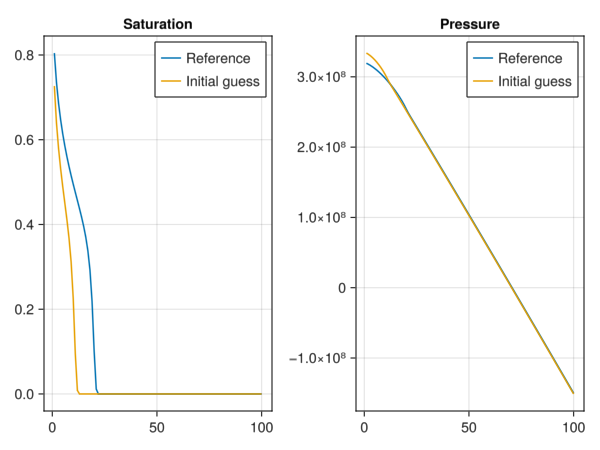

In [6]:
fig = Figure()
ax = Axis(fig[1, 1], title = "Saturation")
lines!(ax, states_ref[end][:Saturations][1, :], label = "Reference")
lines!(ax, states[end][:Saturations][1, :], label = "Initial guess")
axislegend(ax)
ax = Axis(fig[1, 2], title = "Pressure")
lines!(ax, states_ref[end][:Pressure], label = "Reference")
lines!(ax, states[end][:Pressure], label = "Initial guess")
axislegend(ax)
fig

## Define objective function
Define objective as mismatch between water saturation in current state and
reference state. The objective function is currently a sum over all time
steps. We implement a function for one term of this sum.

In [7]:
function mass_mismatch(m, state, dt, step_no, forces)
    state_ref = states_ref[step_no]
    fld = :Saturations
    val = state[fld]
    ref = state_ref[fld]
    err = 0
    for i in axes(val, 2)
        err += (val[1, i] - ref[1, i])^2
    end
    return dt*err
end
@assert Jutul.evaluate_objective(mass_mismatch, model, states_ref, tstep, forces) == 0.0
@assert Jutul.evaluate_objective(mass_mismatch, model, states, tstep, forces) > 0.0

## Set up a configuration for the optimization. This by default enables all parameters for
optimization, with relative box limits 0.1 and 10 specified here. If
use_scaling is enabled the variables in the optimization are scaled so that
their actual limits are approximately box limits.

We are not interested in matching gravity effects or viscosity here.
Transmissibilities are derived from permeability and varies significantly. We
can set log scaling to get a better conditioned optimization system, without
changing the limits or the result.

In [8]:
cfg = optimization_config(model, parameters, use_scaling = true, rel_min = 0.1, rel_max = 10)
for (ki, vi) in cfg
    if ki in [:TwoPointGravityDifference, :PhaseViscosities]
        vi[:active] = false
    end
    if ki == :Transmissibilities
        vi[:scaler] = :log
    end
end
print_obj = 100

100

## Set up parameter optimization.
This gives us a set of function handles together with initial guess and limits.
Generally calling either of the functions will mutate the data Dict. The options are:
F_o(x) -> evaluate objective
dF_o(dFdx, x) -> evaluate gradient of objective, mutating dFdx (may trigger evaluation of F_o)
F_and_dF(F, dFdx, x) -> evaluate F and/or dF. Value of nothing will mean that the corresponding entry is skipped.

In [9]:
F_o, dF_o, F_and_dF, x0, lims, data = setup_parameter_optimization(model, state0, parameters, tstep, forces, mass_mismatch, cfg, print = print_obj, param_obj = true);
F_initial = F_o(x0)
dF_initial = dF_o(similar(x0), x0)
@info "Initial objective: $F_initial, gradient norm $(norm(dF_initial))"

Parameters for model
┌────────────────────┬────────┬─────┬─────────┬─────────────────┬─────────────┬──────────────────────┬─────────┐
│               Name │ Entity │   N │   Scale │     Abs. limits │ Rel. limits │               Limits │ Lumping │
├────────────────────┼────────┼─────┼─────────┼─────────────────┼─────────────┼──────────────────────┼─────────┤
│ Transmissibilities │  Faces │  99 │     log │        [0, Inf] │   [0.1, 10] │ [9.87e-13, 9.87e-11] │       - │
│        FluidVolume │  Cells │ 100 │ default │ [2.22e-16, Inf] │   [0.1, 10] │       [0.0002, 0.02] │       - │
└────────────────────┴────────┴─────┴─────────┴─────────────────┴─────────────┴──────────────────────┴─────────┘
[ Info: Initial objective: 0.6770524183270709, gradient norm 4.12674840425729


## Link to an optimizer package
We use Optim.jl but the interface is general enough that e.g. LBFGSB.jl can
easily be swapped in.

LBFGS is a good choice for this problem, as Jutul provides sensitivities via
adjoints that are inexpensive to compute.

In [10]:
using Optim
lower, upper = lims
inner_optimizer = LBFGS()
opts = Optim.Options(store_trace = true, show_trace = true, time_limit = 30)
results = optimize(Optim.only_fg!(F_and_dF), lower, upper, x0, Fminbox(inner_optimizer), opts)
x = results.minimizer
display(results)
F_final = F_o(x)

Fminbox
-------
Initial mu = 6.83641e-6

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 6.83641e-6

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     6.798720e-01     2.099229e+00
 * time: 0.015545845031738281
     1     1.780925e-01     7.584541e-01
 * time: 3.2487969398498535
     2     1.151245e-01     1.123548e+00
 * time: 4.756019830703735
     3     8.842266e-02     2.023694e+00
 * time: 5.784265995025635
     4     6.519796e-02     1.878007e+00
 * time: 6.827749967575073
     5     4.208136e-02     1.546615e+00
 * time: 8.418540954589844
     6     1.957106e-02     5.221772e-01
 * time: 10.02082085609436
     7     8.242438e-03     1.722439e-01
 * time: 11.5205979347229
     8     6.519070e-03     2.092869e-01
 * time: 12.59438705444336
     9     4.253797e-03     1.057409e-01
 * time: 14.213474035263062
    10     3.232301e-03     1.807707e-02
 * time: 15.309515953063965
    11     3.051258e-03     1.3083

 * Status: failure (exceeded time limit of 30.0)

 * Candidate solution
    Final objective value:     3.283887e-05

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 2.22e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.01e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.83e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   31  (vs limit 30)
    Iterations:    1
    f(x) calls:    56
    ∇f(x) calls:   56


3.2838874984613314e-5

## Compute the solution using the tuned parameters found in x.

In [11]:
parameters_t = deepcopy(parameters)
devectorize_variables!(parameters_t, model, x, data[:mapper], config = data[:config])
x_truth = vectorize_variables(model_ref, parameters_ref, data[:mapper], config = data[:config])

states_tuned, = simulate(state0, model, tstep, parameters = parameters_t, forces = forces, info_level = -1);
nothing

## Plot final parameter spread

[ Info: Final residual 3.2838874984613314e-5 (down from 0.6770524183270709)


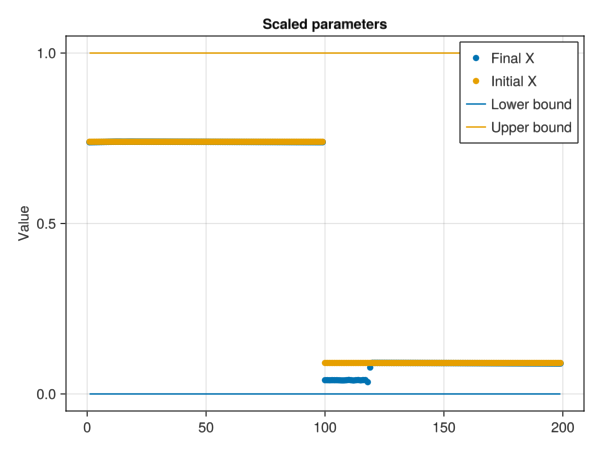

In [12]:
@info "Final residual $F_final (down from $F_initial)"
fig = Figure()
ax1 = Axis(fig[1, 1], title = "Scaled parameters", ylabel = "Value")
scatter!(ax1, x, label = "Final X")
scatter!(ax1, x0, label = "Initial X")
lines!(ax1, lower, label = "Lower bound")
lines!(ax1, upper, label = "Upper bound")
axislegend()
fig

## Plot the final solutions.
Note that we only match saturations - so any match in pressure
is not guaranteed.

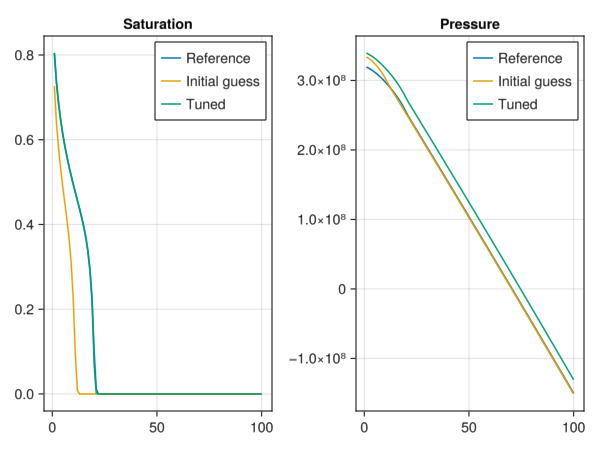

In [13]:
fig = Figure()
ax = Axis(fig[1, 1], title = "Saturation")
lines!(ax, states_ref[end][:Saturations][1, :], label = "Reference")
lines!(ax, states[end][:Saturations][1, :], label = "Initial guess")
lines!(ax, states_tuned[end][:Saturations][1, :], label = "Tuned")

axislegend(ax)
ax = Axis(fig[1, 2], title = "Pressure")
lines!(ax, states_ref[end][:Pressure], label = "Reference")
lines!(ax, states[end][:Pressure], label = "Initial guess")
lines!(ax, states_tuned[end][:Pressure], label = "Tuned")
axislegend(ax)
fig

## Plot the objective history and function evaluations

In [14]:
fig = Figure()
ax1 = Axis(fig[1, 1], yscale = log10, title = "Objective evaluations", xlabel = "Iterations", ylabel = "Objective")
plot!(ax1, data[:obj_hist][2:end])
ax2 = Axis(fig[1, 2], yscale = log10, title = "Outer optimizer", xlabel = "Iterations", ylabel = "Objective")
t = map(x -> x.value, Optim.trace(results))
plot!(ax2, t)
display(fig)

GLMakie.Screen(...)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*